# Миграция Кирхгофа в среде с постоянной скоростью

## 1. Подготовка к расчётам

#### 1.0. Импорт библиотек для Питона

In [1]:
from __future__ import division
import numpy as np
from numpy import sin,cos,tan,pi,sqrt
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
%matplotlib inline

#### 1.1.  Задание сетки, модели  скоростей

На этом этапе зададим 2Д массив `img`, наш временной сейсмический разрез. К нему надо задать координаты по двум осям - `x` и `t`. Для примера возьмем размеры модели 200 $\times$ 300 и шаг 5 м и 5 мс

На начальном этапе заполним этот разрез нулями

In [2]:
#size of each grid cell (X is the spatial coordinate, T is two-way time)
xstep = 2
tstep = 2

#size of the whole grid
xmax = 100
tmax = 90

#arrays of x and t
xarray = np.arange(0, xmax, xstep).astype(float)
tarray = np.arange(0, tmax, tstep).astype(float)

#create a 2D array img, which is now all zeros, but later we will add some amplitudes there
img = np.zeros((len(xarray), len(tarray)))

Покажем получившийся разрез

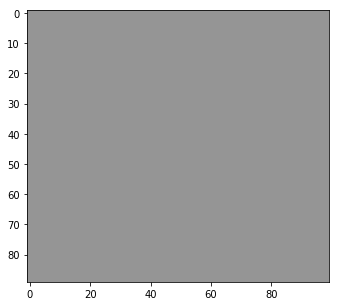

In [3]:
plt.figure(figsize=(7,5), facecolor='w')
plt.imshow(img.T, interpolation = 'none', cmap = cm.Greys, vmin = -1,vmax = 1,
           extent = [xarray[0] - xstep/2, xarray[-1] + xstep/2, tarray[-1] + tstep/2, tarray[0] - tstep/2])


#### 1.2. Создание функции для расчёта времен пробега волны (гиперболы)

На вход функции идут координаты вершин гиперболы (`x0`, `t0`), скорость `v`, а также параметры модели `xarray, tarray, xstep, tstep`. На выходе функция возвращает:
- `x_hyp, t_hyp` - координаты всех точек изображения, лежащих вдоль траектории гиперболы
- `t_discrete` - дискретизированные (с точностью до `xstep`) значения времени
- `x_index, t_index` - координаты (номера ячеек) изображения `img`, которым соответствуют значения `x_hyp`, `t_discrete`

In [4]:
def hyperbola (xarray, tarray, xstep, tstep, x0, t0, v = 2):
    # traveltimes
    x_hyp = xarray
    t_hyp = sqrt(t0**2 + (2*(x_hyp-x0)/v)**2)
    

   
    # make sure that t does not exceed tmax and t_index < len(tarray)
    x_hyp = x_hyp[t_hyp < max(tarray) - tstep]
    t_hyp = t_hyp[t_hyp < max(tarray) - tstep]

    
    # grid cells coordinates
    # to assign the amplutudes to the image points, need discretization
    t_index = np.round((t_hyp - tarray[0])/tstep).astype(int)
    x_index = np.round((x_hyp - xarray[0])/xstep).astype(int)
        
    t_discrete = tarray[t_index]
    
        
    # amplitudes
    amp = 1/(t_hyp/t0)
    
    
    return x_hyp, t_hyp, x_index, t_index, t_discrete, amp
    
    

#### 1.3. Тест функции для расчёта гиперболы

Посмотрим, как это работает

Создадим тестовую гиперболу и нарисуем линию гиперболы и дискретизированные точки

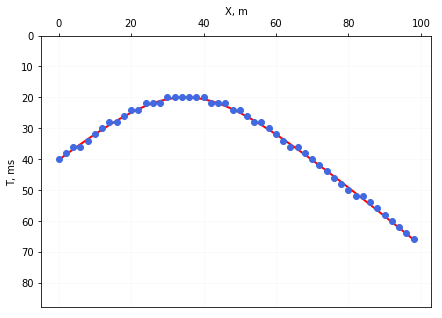

In [6]:
x_hyp_test, t_hyp_test, x_index_test, t_index_test, t_discrete_test, amp = hyperbola(xarray,tarray, xstep, tstep, x0 = 35, t0 = 20, v=2)

#Create a fugure and add axes to it
fgr_test1 = plt.figure(figsize=(7,5), facecolor='w')
ax_test1 = fgr_test1.add_subplot(111)

#Now plot Hyp_test's parameters: X vs T
ax_test1.plot(x_hyp_test, t_hyp_test, 'r', lw = 2)
ax_test1.plot(x_hyp_test, t_discrete_test, 'royalblue', lw = 0, marker = 'o')


#Some commands to add gridlines, change the directon of T axis and move x axis to top
ax_test1.set_ylim(tarray[-1],tarray[0])
ax_test1.xaxis.set_ticks_position('top')
ax_test1.grid(True, alpha = 0.1, ls='-',lw=.5)

ax_test1.set_xlabel('X, m')
ax_test1.set_ylabel('T, ms')
ax_test1.xaxis.set_label_position('top')

plt.show()

## 2. Создание модели среды. Решение прямой задачи - моделирование временного разреза

Так. Теперь, чтобы было что мигрировать, надо создать некое подобие временного разреза. У нас для простоты разрез будет состоять из объектов двух типов:

1. Точечный дифрактор - определяется своими координатами $(x_0, t_0)$. 
2. Линейный элемент отражающей поверхности - Определяется координатами своих концов $(x_1, t_1)$ и $(x_2, t_2)$

Сделаем разрез, на котором будет несколько линий и несколько гипербол, соответствующих дифракторам.
Начнем с дифракторов.

#### 2.1. Создание нескольких дифрагирующих объектов и расчёт их откликов

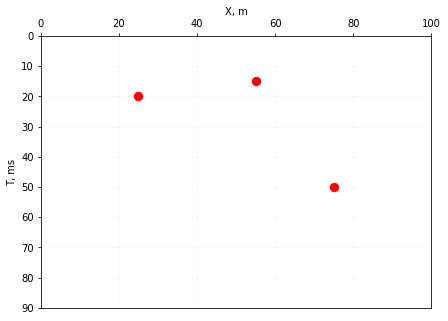

In [7]:
point_diff_x0 = [25, 55, 75]
point_diff_t0 = [20, 15, 50]


plt.figure(figsize=(7,5), facecolor='w')
plt.scatter(point_diff_x0,point_diff_t0, c='r', s=70)
plt.xlim(0, xmax)
plt.ylim(tmax, 0)
plt.gca().set_xlabel('X, m')
plt.gca().set_ylabel('T, ms')
plt.gca().xaxis.set_ticks_position('top')
plt.gca().xaxis.set_label_position('top')
plt.gca().grid(True, alpha = 0.1, ls='-',lw=.5)

Теперь надо для каждого из дифракторов рассчитать его отклик. Вызываем для кажддого из них функцию `hyperbola`, написанную ранее, и рассчитываем времена пробега.


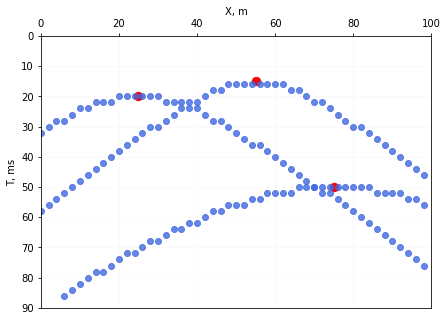

In [8]:
fgr2 = plt.figure(figsize=(7,5), facecolor='w')
ax2 = fgr2.add_subplot(111)

for x0_i, t0_i in zip(point_diff_x0,point_diff_t0):
    x_hyp_i, t_hyp_i, x_index_i, t_index_i, t_discrete_i, amp_i = hyperbola(xarray,tarray, xstep, tstep, x0_i, t0_i, v=2)
    ax2.plot(x_hyp_i, t_discrete_i, 'royalblue', lw = 0, marker = 'o', alpha=0.8)

ax2.scatter(point_diff_x0,point_diff_t0, c='r',s=70)
ax2.set_xlim(0, xmax)
ax2.set_ylim(tmax, 0)    
ax2.set_xlabel('X, m')
ax2.set_ylabel('T, ms')
ax2.xaxis.set_ticks_position('top')
ax2.xaxis.set_label_position('top')
ax2.grid(True, alpha = 0.1, ls='-',lw=.5)

Остается только прикрутить к каждой точке на траектории гиперболы импульс и прибавить все это к амплитудам временного разреза.

![Image, width = 400](http://risovach.ru/upload/2018/01/mem/kanalya_167204216_orig_.jpg)


#### 2.2. Быстро принимаемся за импульс

(-3, 3)

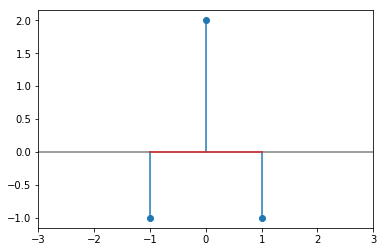

In [9]:
wav1 = np.array([-1, 2, -1])

plt.axhline(0,c='k', alpha = 0.5)
plt.stem((np.arange(len(wav1)) - np.floor(len(wav1)/2)).astype(int), wav1)

plt.xlim(-len(wav1), len(wav1))

Ура. `wav1` - наш супер-импульс из трех отсчётов

Ок, наконец добавляем гиперболы на временной разрез

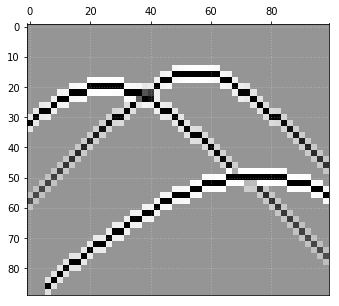

In [10]:
fgr3 = plt.figure(figsize=(7,5), facecolor='w')
ax3 = fgr3.add_subplot(111)

for x0_i, t0_i in zip(point_diff_x0,point_diff_t0):
    x_hyp_i, t_hyp_i, x_index_i, t_index_i, t_discrete_i, amp_i = hyperbola(xarray,tarray, xstep, tstep, x0_i, t0_i, v=2)
    for iwav, amp_wav in enumerate(wav1):
        img[x_index_i,t_index_i + iwav-int(len(wav1)/2)] = img[x_index_i,t_index_i + iwav-int(len(wav1)/2)] + amp_i*amp_wav


plt.imshow(img.T,interpolation='none',cmap=cm.Greys, vmin=-1,vmax=1, extent=[xarray[0]-xstep/2, xarray[-1]+xstep/2, tarray[-1]+tstep/2, tarray[0]-tstep/2])
plt.gca().xaxis.set_ticks_position('top')
plt.gca().grid(ls=':', alpha=0.25, lw=1, c='w' )

Ну и парочку линий:

In [11]:
x_start_line = [10, 20]
t_start_line = [40, 60]
x_end_line = [65, 90]
t_end_line = [70, 40]


for line_no in xrange(len(x_start_line)):
    x1 = int((x_start_line[line_no]-xarray[0])/xstep)
    x2 = int((x_end_line[line_no]-xarray[0])/xstep)
    t1 = int((t_start_line[line_no]-tarray[0])/tstep)
    t2 = int((t_end_line[line_no]-tarray[0])/tstep)
    
    line_x = np.arange(x1, x2).astype(int)
    line_t = (t1+(t2-t1)*(line_x-x1)/(x2-x1)).astype(int)
    for iwav, amp_wav in enumerate(wav1):
        img[line_x, line_t + iwav-int(len(wav1)/2)] = img[line_x, line_t + iwav-int(len(wav1)/2)] + amp_wav
    

Покажем, что наконец у нас получилось

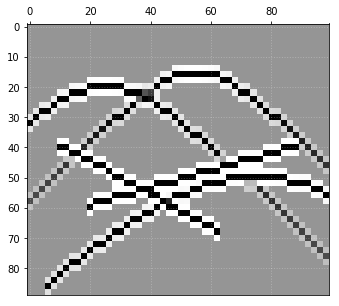

In [12]:
plt.figure(figsize=(7,5), facecolor='w')
plt.imshow(img.T, interpolation='none', cmap=cm.Greys, vmin=-1, vmax=1, 
           extent=[xarray[0]-xstep/2, xarray[-1]+xstep/2, tarray[-1]+tstep/2, tarray[0]-tstep/2])
plt.gca().xaxis.set_ticks_position('top')
plt.gca().grid(ls=':', alpha=0.25, lw=1, c='w' )

Ок супер, вот и закончили с временным разрезом

![Image](http://risovach.ru/upload/2018/01/mem/otchayannyy-agutin_167216126_orig_.jpg)

## 3. Задание функции для расчёта миграции Кирхгофа

Поскольку миграция определяется в нашем случае как суммирование вдоль множества гипербол, соответствующая функция будет принимать в качестве входных параметров: временной разрез `img`, скорость `v`, параметры модели `xarray, tarray, xstep, tstep`, a также апертуру миграции `aper`. На выходе функция возвращает мигрированное изображение


In [13]:
def migrate(img, vmig, aper, xarray, tarray, xstep, tstep):
    imgmig=np.zeros_like(img)
    xstep=xarray[1]-xarray[0]

    for x0_j in xarray[1:-1]:    
        for t0_j in tarray[1:-2]:
            #only a region between (x0-aper) and (x0+aper) should be taken into account
            xmig = xarray[(xarray >= x0_j-aper) & (xarray <= x0_j+aper)]
            
            x_h_j, t_h_j, x_index_j, t_index_j, t_discrete_j, amp_j = hyperbola(xmig, tarray, xstep, tstep, x0_j, t0_j, v = vmig)
            migind_start = x_h_j[0]/xstep
            migind_stop = (x_h_j[-1]+xstep)/xstep

            
            imgind = np.arange(migind_start, migind_stop).astype(int)
            #Sum (in fact, count the mean value of) all the amplitudes on current hyperbola hi
            si = np.mean(img[imgind, t_index_j]*amp_j)
            
            imgmig[int(x0_j/xstep), int(t0_j/tstep)] = si

    return imgmig
            

## 4. Расчёт миграции

 Функция написана, надо только задать ее параметры - апертуру и скорость - и вызвать.

In [14]:
vmig = 2.0
aper = 100
res = migrate(img, vmig, aper, xarray, tarray, xstep, tstep)

Классно, теперь посмотрим, что получилось...

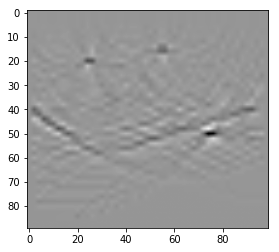

In [15]:
plt.imshow(res.T, interpolation='bilinear',cmap=cm.Greys, vmin = -1, vmax =1, 
           extent=[xarray[0]-xstep/2, xarray[-1]+xstep/2, tarray[-1]+tstep/2, tarray[0]-tstep/2])


Красота! Вроде работает.
Потестируем разные параметры.

## 5. Изменение скорости и апертуры

#### 5.1. Зависимость результата миграции от погрешности скоростей

Зададим три разные скорости:
- 1.8 км/с (-10 %  от истинной скорости)
- 2.0 км/с (истинная скорость)
- 2.2 км/с (+10 %  от истинной скорости)

Смигрируем и посмотрим на результат

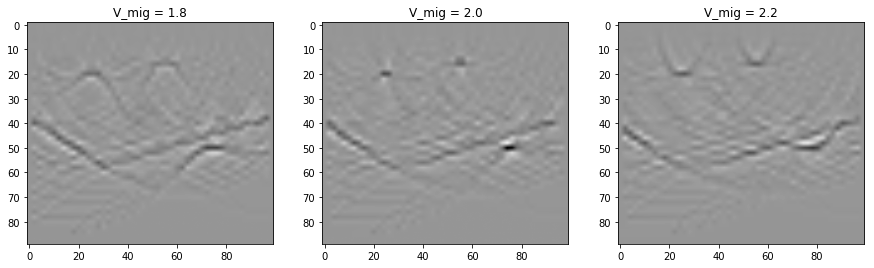

In [16]:
vmig_var = [1.8, 2.0, 2.2]   #migration velocities to test
res_var = []    #empty list
f_vmig_var, ax_vmig_var = plt.subplots(1,len(vmig_var), figsize = (15,10))
for i, vmig_i in enumerate(vmig_var):
    res_var.append(migrate(img, vmig_i, aper, xarray, tarray, xstep, tstep))
    
    # display
    ax_vmig_var[i].imshow(res_var[i].T, interpolation='bilinear',cmap=cm.Greys, vmin = -1, vmax =1, 
           extent=[xarray[0]-xstep/2, xarray[-1]+xstep/2, tarray[-1]+tstep/2, tarray[0]-tstep/2])
    ax_vmig_var[i].set_title(r'V_mig = {0}'.format(vmig_i))


#### 5.2. Зависимость результата от выбора апертуры

Зададим три разные апертуры:
- 20 м
- 40 м
- 60 м

Смигрируем и посмотрим на результат

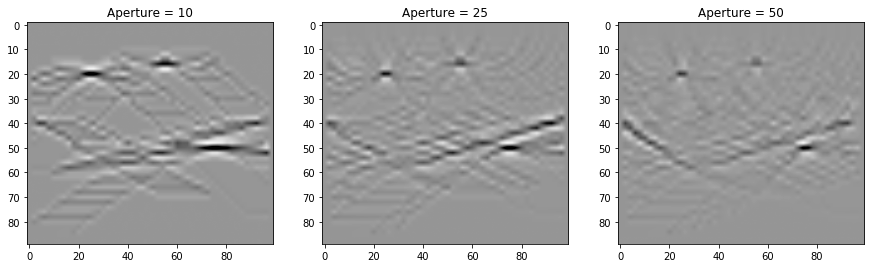

In [17]:
aper_var = [10, 25, 50]   #migration velocities to test
res_var_aper = []    #empty list
f_aper_var, ax_aper_var = plt.subplots(1,len(aper_var), figsize = (15,10))
for i, aper_i in enumerate(aper_var):
    res_var_aper.append(migrate(img, vmig, aper_i, xarray, tarray, xstep, tstep))
    
    # display
    ax_aper_var[i].imshow(res_var_aper[i].T, interpolation='bilinear',cmap=cm.Greys, vmin = -1, vmax =1, 
           extent=[xarray[0]-xstep/2, xarray[-1]+xstep/2, tarray[-1]+tstep/2, tarray[0]-tstep/2])
    ax_aper_var[i].set_title(r'Aperture = {0}'.format(aper_i))

#### 5.3. Еще один пример с апертурой

Для наглядности создадим еще одну модель и посмотрим, как качество результата зависит от наклона мигрируемых границ и апертуры.

Чтобы картинка была посимпатичнее, сделаем побольше размер модели, но считаться может долго!

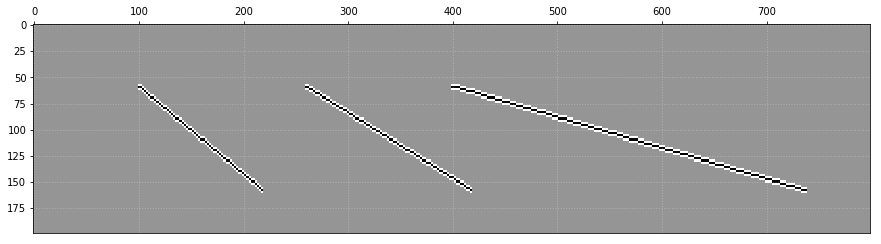

In [18]:
#size of the whole grid
xmax_ap = 800
tmax_ap = 200

#arrays of x and t
xarray_ap = np.arange(0, xmax_ap, xstep).astype(float)
tarray_ap = np.arange(0, tmax_ap, tstep).astype(float)

#create a 2D array img, which is now all zeros, but later we will add some amplitudes there
img_ap = np.zeros((len(xarray_ap), len(tarray_ap)))

x_start_line_ap = [100, 260, 400]
t_start_line_ap = [60, 60, 60]
x_end_line_ap = [220, 420, 740]
t_end_line_ap = [160, 160, 160]


for line_no in xrange(len(x_start_line_ap)):
    x1 = int((x_start_line_ap[line_no]-xarray_ap[0])/xstep)
    x2 = int((x_end_line_ap[line_no]-xarray_ap[0])/xstep)
    t1 = int((t_start_line_ap[line_no]-tarray_ap[0])/tstep)
    t2 = int((t_end_line_ap[line_no]-tarray_ap[0])/tstep)
    
    line_x = np.arange(x1, x2).astype(int)
    line_t = (t1+(t2-t1)*(line_x-x1)/(x2-x1)).astype(int)
    for iwav, amp_wav in enumerate(wav1):
        img_ap[line_x, line_t + iwav-int(len(wav1)/2)] = img_ap[line_x, line_t + iwav-int(len(wav1)/2)] + amp_wav

        
plt.figure(figsize=(15,10), facecolor='w')
plt.imshow(img_ap.T, interpolation='none', cmap=cm.Greys, vmin=-1, vmax=1, 
           extent=[xarray_ap[0]-xstep/2, xarray_ap[-1]+xstep/2, tarray_ap[-1]+tstep/2, tarray_ap[0]-tstep/2], aspect=1)
plt.gca().xaxis.set_ticks_position('top')
plt.gca().grid(ls=':', alpha=0.25, lw=1, c='w' )

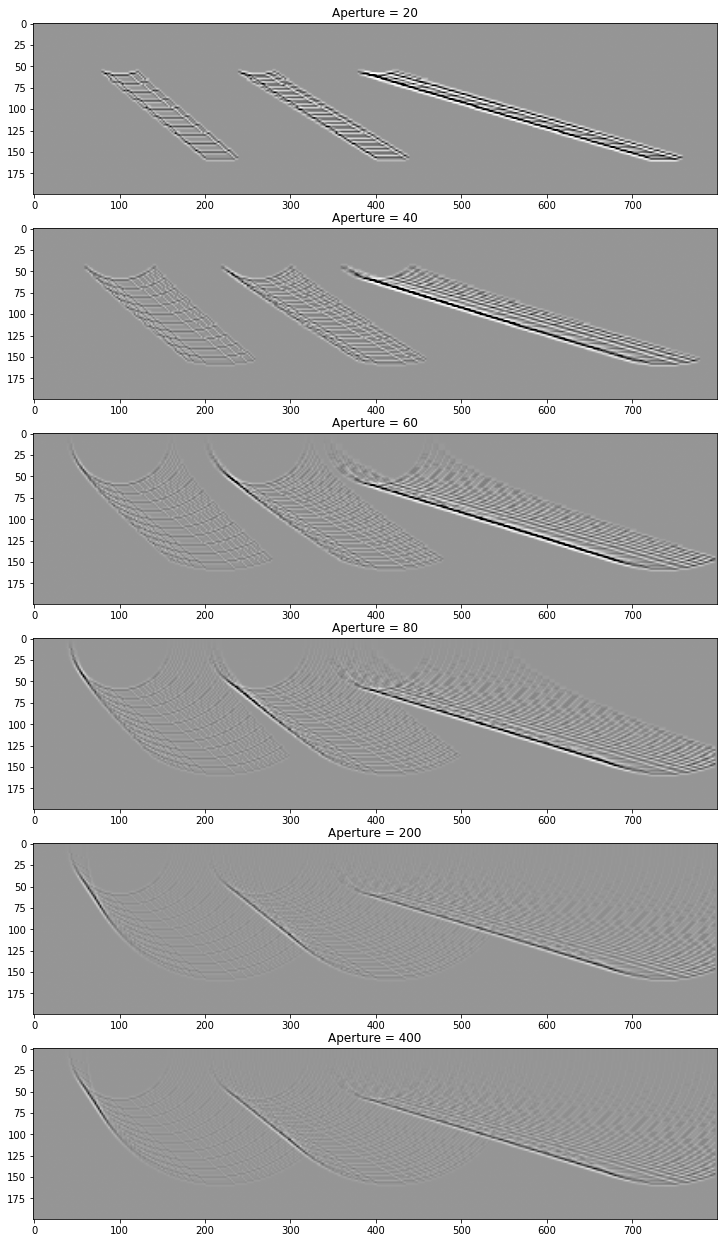

In [19]:
aper_var2 = [20, 40, 60, 80, 200, 400]   #migration velocities to test
res_var_aper2 = []    #empty list
f_aper_var2, ax_aper_var2 = plt.subplots(len(aper_var2),1, figsize = (15,22))
for i, aper_i in enumerate(aper_var2):
    res_var_aper2.append(migrate(img_ap, vmig, aper_i, xarray_ap, tarray_ap, xstep, tstep))
    
    # display
    ax_aper_var2[i].imshow(res_var_aper2[i].T, interpolation='bilinear',cmap=cm.Greys, vmin = -0.2, vmax = 0.2, 
           extent=[xarray_ap[0]-xstep/2, xarray_ap[-1]+xstep/2, tarray_ap[-1]+tstep/2, tarray_ap[0]-tstep/2])
    ax_aper_var2[i].set_title(r'Aperture = {0}'.format(aper_i))